<a href="https://colab.research.google.com/github/bruceyanwee/BruceTech2019/blob/master/captcha_new_styles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 项目说明 
基于前面的模型和训练结果
根据新的给定不同字体、不同字符间隔的图片
重新训练针对该“模式”下的验证码识别


# 导入要用到的包

In [1]:
import torch
from PIL import Image
import random
import time
import os
import numpy as np
from torch.autograd import Variable
!/opt/bin/nvidia-smi

Tue Apr 21 12:06:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 外部数据处理方式
可以直接挂载到Google drive，但是可能io会影响到读取速度，而且本实验的数据可以模拟生成，故：才去每次试验前生成数据，10w条train大概需要8分钟

In [0]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/My Drive"
# os.chdir(path)

# 一些配置参数，存储路径、字符长度、字符种类，字体设置、验证码噪声等等

In [0]:
# 需要用到的一些验证码的常量
# 验证码中的字符
# string.digits + string.ascii_uppercase
CHAR_SET = '0123456789'+'ABCDEFGHIJKLMNOPQRSTUVWXYZ'+'abcdefghijklmnopqrstuvwxyz'						  # 图片字符集合
CPATCHA_LEN = 4									  # 每张图片字符的个数
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
ALPHABET2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
# 所有字符类别集
ALL_CHAR_SET = NUMBER + ALPHABET + ALPHABET2
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
# 一张图片中字符的个数
MAX_CAPTCHA = 4
# 图像大小
IMAGE_HEIGHT = 60
IMAGE_WIDTH = 160
# IMAGE_HEIGHT = 28
# IMAGE_WIDTH = 73
# 离线训练模式的数据存取路径设置
TRAIN_DATASET_PATH = 'dataset' + os.path.sep + 'chr_len_62_ss'+ os.path.sep + 'train'
VAL_DATASET_PATH = 'dataset' + os.path.sep + 'chr_len_62_ss'+ os.path.sep + 'val'
TEST_DATASET_PATH = 'dataset' + os.path.sep + 'chr_len_62_ss'+ os.path.sep + 'test'
PREDICT_DATASET_PATH = 'dataset' + os.path.sep + 'predict'
# 超参数
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EXPORT_FILE_NAME = 'deploy_captcha.pth'

# 完整流程包括以下四步
1. Prepare data    数据准备
2. Build model     模型定义
3. Train model     训练模型
4. Analyse results 分析结果

## 1. 准备数据 ETL 阶段

In [0]:
# 对label进行one-hot 编码
def encode(text):
    vector = np.zeros(ALL_CHAR_SET_LEN * MAX_CAPTCHA, dtype=float)
    def char2pos(c):
        if c =='_':
            k = 62
            return k
        k = ord(c)-48
        if k > 9:
            k = ord(c) - 65 + 10
            if k > 35:
                k = ord(c) - 97 + 26 + 10
                if k > 61:
                    raise ValueError('error')
        return k
    for i, c in enumerate(text):
        idx = i * ALL_CHAR_SET_LEN + char2pos(c)
        vector[idx] = 1.0
    return vector
def decode(vec):
    char_pos = vec.nonzero()[0]
    text=[]
    for i, c in enumerate(char_pos):
        char_at_pos = i #c/63
        char_idx = c % ALL_CHAR_SET_LEN
        if char_idx < 10:
            char_code = char_idx + ord('0')
        elif char_idx <36:
            char_code = char_idx - 10 + ord('A')
        elif char_idx < 62:
            char_code = char_idx - 36 + ord('a')
        elif char_idx == 62:
            char_code = ord('_')
        else:
            raise ValueError('error')
        text.append(chr(char_code))
    return "".join(text)
# 把一批图片的labels的onehot转换成标签编码
# ys_one_hot.shape = [batch_size,4*len(CHAR_SET)]
def onehot2labelcode(ys_one_hot):
    labels_code = []
    for i in range(ys_one_hot.shape[0]):
        label_code = []
        for j in range(CPATCHA_LEN):
            label_code.append(np.argmax(ys_one_hot[i,j*ALL_CHAR_SET_LEN:(j+1)*ALL_CHAR_SET_LEN]).item())
        labels_code.append(label_code)
    return torch.tensor(labels_code)

### 1.1离线数据集dataset（采样）

In [5]:
# 数据准备
# 生成验证码的代码片段
! pip install captcha
from captcha.image import ImageCaptcha
# 产生随机的四个字符
def random_captcha():
    captcha_text = random.choices(ALL_CHAR_SET,k=MAX_CAPTCHA)
    return ''.join(captcha_text)
# 生成字符对应的验证码
def gen_captcha_text_and_image():
    image = ImageCaptcha(width=IMAGE_WIDTH,height=IMAGE_HEIGHT)
    captcha_text = random_captcha()
    captcha_image = Image.open(image.generate(captcha_text))
    return captcha_text, captcha_image
def captcha_gen(model_choose = 'train',num=1000):
    count = num
    if model_choose=='train':
        path = TRAIN_DATASET_PATH
    if model_choose=='test':
        path = TEST_DATASET_PATH  #通过改变此处目录，以生成 训练、测试和预测用的验证码集
    if model_choose=='val':
        path = VAL_DATASET_PATH
    if not os.path.exists(path):
        os.makedirs(path)
    for i in range(count):
        now = str(int(time.time()))
        text, image = gen_captcha_text_and_image()
        filename = text+'_'+now+'.png'
        image.save(path  + os.path.sep +  filename)
        print('saved %d : %s' % (i+1,filename))
# 制作数据集
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
class mydataset(Dataset):
    def __init__(self, folder, transform=None):
        self.train_image_file_paths = [os.path.join(folder, image_file) for image_file in os.listdir(folder)]
        self.transform = transform
    def __len__(self):
        return len(self.train_image_file_paths)
    def __getitem__(self, idx):
        image_root = self.train_image_file_paths[idx]
        image_name = image_root.split(os.path.sep)[-1]
        image = Image.open(image_root)
        if self.transform is not None:
            image = self.transform(image)
        label = encode(image_name.split('_')[0]) # 为了方便，在生成图片的时候，图片文件的命名格式 "4个数字或者数字_时间戳.PNG", 4个字母或者即是图片的验证码的值，字母大写,同时对该值做 one-hot 处理
        return image, label
transform = transforms.Compose([
    # transforms.ColorJitter(),
    transforms.Grayscale(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def get_train_data_loader(batch_size=64):
    dataset = mydataset(TRAIN_DATASET_PATH, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)
def get_val_data_loader(batch_size=64):
    dataset = mydataset(VAL_DATASET_PATH, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)
def get_test_data_loader():
    dataset = mydataset(TEST_DATASET_PATH, transform=transform)
    return DataLoader(dataset, batch_size=1, shuffle=True)
def get_predict_data_loader():
    dataset = mydataset(PREDICT_DATASET_PATH, transform=transform)
    return DataLoader(dataset, batch_size=1, shuffle=True)

     |████████████████████████████████| 102kB 2.2MB/s 


### 1.2在线数据集dataset（总体）--不区分训练验证测试，因为训练集的也不会重复
注意：label也要编码成one-hot的格式，总之要与模型输出与损失函数相对应
CNN_captcha：5层，多标签的损失函数
CNN:8层，多标签损失函数

In [0]:
class mydataset_online(Dataset):
    def __init__(self, width=IMAGE_WIDTH, height=IMAGE_HEIGHT, char_length=4, input_channel=1, char_set=CHAR_SET, len_set = 64*100,group_len=8,fonts=None, font_sizes=None):
        """在线生成图片用于模型训练
        :param width: 图像的宽度
        :param height: 图像的高度
        :param char_length: 每张图像包含的字符长度
        :param input_channel: 生成图像的通道数，1对应着灰度图，3对应着RGB图像
        :param char_set: 候选字符集合
        :param fonts: 字体文件路径
        :param font_sizes: 字体大小
        """
        self.transform = transforms.ToTensor()
        self.input_channel = input_channel
        self.char_set = char_set
        self.captcha_generator = ImageCaptcha(width=width, height=height, fonts=fonts, font_sizes=font_sizes)
        self.len_set = len_set
        self.group_len = group_len
        self.char_length = char_length
    def __getitem__(self, item):
        return self.gen_captcha()

    def gen_captcha(self):
        """每一个标签生成8张图像
        """
        chars = random.choices(self.char_set, k=self.char_length)
        label = encode(chars) # one-hot 型的label
        image_tensors = []
        image_labels = []
        if self.input_channel == 1:
            mode = 'L'
        elif self.input_channel == 3:
            mode = 'RGB'
        else:
            raise ValueError("Unknown input_channel value: {}".format(self.input_channel))
        for i in range(self.group_len):
            cap_img = self.captcha_generator.generate_image(chars).convert(mode)
            image_tensors.append(self.transform(cap_img))
            image_labels.append(torch.tensor(label))

        image_tensors = torch.stack(image_tensors, 0)
        image_labels = torch.stack(image_labels, 0)

        return image_tensors, image_labels

    def __len__(self):
        return self.len_set
def get_train_data_loader_online(batch_size=BATCH_SIZE,len_set = BATCH_SIZE*200,group_len=2):
    dataset = mydataset_online(len_set = len_set,group_len=group_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def get_val_data_loader_online(batch_size=BATCH_SIZE,len_set = BATCH_SIZE*10,group_len=2):
    dataset = mydataset_online(len_set = len_set,group_len=group_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

## 2. 模型定义
这里包括了两个模型

*   基础的3层卷积+2层全连接
*   更深一点的6层卷积+2层全连接



### 2.1 浅层（5）模型

In [0]:
# 模型定义
# 模型1：浅层的模型
import torch.nn as nn
class CNN_captcha(nn.Module):
    def __init__(self):
        super(CNN_captcha,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # (batch_size=64,num_channel=1,60,160)-->(batch_size=64,num_channel=32,60,160)
            nn.BatchNorm2d(32),                         # 参数个数：卷积核个数 32 * 每个卷积核 3x3=9 = 288
            # nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))                            # (batch_size=64,num_channel=32,60,160)-->(batch_size=64,num_channel=32,30,80)
        self.layer2 = nn.Sequential(                    
            nn.Conv2d(32, 64, kernel_size=3, padding=1),# (batch_size=64,num_channel=32,30,80)-->(batch_size=64,num_channel=64,30,80)
            nn.BatchNorm2d(64),                         # 参数个数：卷积核个数 64 * 每个卷积核 3x3=9 = 576
            # nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))                            # (batch_size=64,num_channel=64,30,80)-->(batch_size=64,num_channel=64,15,40)
        self.layer3 = nn.Sequential(                    
            nn.Conv2d(64, 64, kernel_size=3, padding=1),# (batch_size=64,num_channel=64,15,40)-->(batch_size=64,num_channel=64,15,40)
            nn.BatchNorm2d(64),                         # 参数个数：卷积核个数 64 * 每个卷积核 3x3=9 = 576
            # nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU(),      
            nn.MaxPool2d(2))                            # (batch_size=64,num_channel=64,15,40)-->(batch_size=64,num_channel=64,7,20)
        self.fc = nn.Sequential(                        
            nn.Linear((IMAGE_WIDTH//8)*(IMAGE_HEIGHT//8)*64, 1024), # (batch_size=64,num_channel=64,7,20).view(out.size(0), -1)-->(batch_size=64,8960)-->(batch_size=64,1024)
            nn.Dropout(0.5),  # drop 50% of the neuron              # 参数个数：全连接 上一层 8960 * 下一层 1024 = 900w
            nn.ReLU())
        self.rfc = nn.Sequential(
            nn.Linear(1024, MAX_CAPTCHA*ALL_CHAR_SET_LEN),# (batch_size=64,1024)-->(batch_size=64,MAX_CAPTCHA*ALL_CHAR_SET_LEN=4*36=144)
        )                                                 # 参数个数：1024 * 144 = 14w
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.rfc(out)
        return out

### 2.2 深层（8）模型

In [0]:
# ************************ step-2 Build model ************************
# CNN的结构
# 卷积块的结构
# padding为了大小不变，pool为了尺寸减半
def conv_block(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)
    )
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.feature_extractor = nn.Sequential(
          conv_block(1, 32),
          conv_block(32, 64),
          conv_block(64, 96),
        )
        self.fc = nn.Sequential(
          nn.Linear((IMAGE_WIDTH//8)*(IMAGE_HEIGHT//8)*96, 1024),   # TODO: 2592可能随着输入维度的改变需要调整
          nn.Dropout(0.5),  # drop 50% of the neuron
          nn.ReLU(),
          nn.Linear(1024, CPATCHA_LEN * len(CHAR_SET))
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)   # 如果用one-hot的话，多标签分类的话就用这个模型的输出[batch_size,4*62]
        # logits = logits.view((-1, len(CHAR_SET), CPATCHA_LEN)) # 用交叉熵损失的时候，就用这个模型的输出 [batch_size,62,4]
        return logits

## 3. 模型训练
包括：
*   优化器的选择
*   损失函数的选择
    *   损失函数改变，模型最后一层的输出的形式要与之匹配
*   batch_size、learning_rate的选择
*   训练过程的可视化
*   通过可视化重新调整


### 3.1 训练方式一（在线）
*  直接在dataset里面的__get_item__方法中generator生成
*  优点：不存在训练集不够的情况，训练、验证、测试不用分开，相当于知道了数据的生成模型（上帝视角）
*  缺点：速度慢、GPU利用率不高，所以不利于模型调参


In [0]:
# ************************ step-3 Train model ************************
def train_online(num_epochs=10,batch_size=BATCH_SIZE,learning_rate = LEARNING_RATE,model_file_name =EXPORT_FILE_NAME):
    # 用于记录训练过程的loss和acc
    train_loss_rcd = []
    val_loss_rcd = []
    val_acc_rcd = []
    cnn = CNN()
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn=cnn.to(device)
    cnn.train()
    print('init net')
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    train_dataloader = get_train_data_loader_online(batch_size=batch_size)
    val_dataloader = get_val_data_loader_online()
    for epoch in range(num_epochs):
        cnn.train()
        for i, (x, y) in enumerate(train_dataloader):
            x = torch.flatten(x.to(device),0,1)
            y = torch.flatten(y.to(device),0,1)
            y_preds = cnn(x)
            train_loss = criterion(y_preds,y)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            group_acc, single_acc = accuracy_one_hot_code(y, y_preds)
            if (i+1) % 10 == 0:
                print("epoch:{:03d} Batch:{:02d} - train_Loss: {:.4f}, SingleAcc: {:.4f}, GroupAcc: {:.4f}"
                 .format(epoch, i+1, train_loss.item(),single_acc,group_acc))
        # 每个epoch保存一下
        torch.save(cnn.state_dict(), EXPORT_FILE_NAME)   #current is model.pkl
        print("save model")
        # 训练过程中，用val来观测是否过拟合
        with torch.no_grad():
            cnn.eval()
            count = 0
            correct = 0
            total = 0
            val_loss_avg = 0
            for i, (x, y) in enumerate(val_dataloader):
                x = torch.flatten(x.to(device),0,1)
                y = torch.flatten(y.to(device),0,1)
                y_preds = cnn(x)
                val_loss = criterion(y_preds, y)
                val_loss_avg = val_loss_avg + val_loss.item()
                count+=1 
                # 计算acc
                predict_label = y_preds.detach().cpu()
                y = y.detach().cpu()
                for j in range(predict_label.shape[0]): # 对一个batch里做循环 第j张图片
                    predict_label_str = ''
                    for k in range(MAX_CAPTCHA):
                        predict_label_str = predict_label_str + ALL_CHAR_SET[np.argmax(predict_label[j, (k)*ALL_CHAR_SET_LEN:(k+1) * ALL_CHAR_SET_LEN].data.numpy())]
                    true_label = decode(y.numpy()[j])
                    total += 1
                    if(predict_label_str == true_label):
                        correct += 1
            print("epoch:", epoch, "train_loss:", train_loss.item(),"val_loss:", val_loss_avg/count)
            print('Val Accuracy of the model on the %d test images: %f %%' % (total, 100 * correct / total))
            # 添加记录
            val_acc_rcd.append(correct / total)
            train_loss_rcd.append(train_loss.item())
            val_loss_rcd.append(val_loss_avg/count)
    torch.save(cnn.state_dict(), EXPORT_FILE_NAME)   #current is model.pkl
    print("save last model")
    return train_loss_rcd,val_loss_rcd,val_acc_rcd
# ************************ step-4  Analyse results ************************
# 
def accuracy_label_code(y_true, logits):
    y_pred = logits.max(1)[1]
    eq_boolean = torch.eq(y_true, y_pred)
    group_acc = torch.all(eq_boolean, dim=1).float().mean()
    single_acc = eq_boolean.float().mean()
    return group_acc.item(), single_acc.item()

def accuracy_one_hot_code(y_ture,y_pred):
    y_pred = y_pred.detach().cpu()
    y_ture = y_ture.detach().cpu()
    y_pred = y_pred.view((-1, len(CHAR_SET), CPATCHA_LEN))
    y_ture = onehot2labelcode(y_ture)
    return accuracy_label_code(y_ture,y_pred)


### 3.2 训练方式2 （离线）
*  生成图片-->保存本地-->dataset读取-->包装成dataloader
*  优点：GPU利用率高，训练速度快，利于模型调参
*  缺点：不知道需要多少train的量，需要不断的生成样本，相当于采样，所以训练、验证、测试需要分开


In [0]:
# 训练代码
# Hyper Parameters
def train(num_epochs=30,train_model='fast_model',batch_size_train=64,learning_rate = 0.001):
    # 可视化训练过程
    train_loss_rcd = []
    val_loss_rcd = []
    val_acc = []
    cnn = CNN()
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn=cnn.to(device)
    cnn.train()
    print('init net')
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    # Train the Model
    train_dataloader = get_train_data_loader(batch_size=batch_size_train)
    for epoch in range(num_epochs):
        cnn.train()
        for i, (images, labels) in enumerate(train_dataloader):
            images = Variable(images).to(device)
            labels = Variable(labels.float()).to(device)
            predict_labels = cnn(images)
            train_loss = criterion(predict_labels, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            if (i+1) % 10 == 0:
                print("epoch:", epoch, "batchs:", i+1, "loss:", train_loss.item())
            if (i+1) % 100 == 0:
                torch.save(cnn.state_dict(), "./model.pkl")   #current is model.pkl
                print("save model")
        # 训练过程中，用val来观测是否过拟合
        cnn.eval()
        val_dataloader = get_val_data_loader(batch_size=64)
        count = 0
        val_loss_avg = 0
        for i, (images, labels) in enumerate(val_dataloader):
            images = Variable(images).to(device)
            labels = Variable(labels.float()).to(device)
            predict_labels = cnn(images)
            val_loss = criterion(predict_labels, labels)
            val_loss_avg = val_loss_avg + val_loss.item()
            count+=1 
        print("epoch:", epoch, "batchs:", i+1, "train_loss:", train_loss.item(),"val_loss:", val_loss_avg/count)
        ## 打印出分类accuracy，因为loss降低，acc并不一定高
        if train_model == 'acc_model': 
            cnn.eval()
            val_dataloader = get_val_data_loader(batch_size=1)
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(val_dataloader):
                image = images
                vimage = Variable(image).to(device)
                predict_label = cnn(vimage)
                predict_label = predict_label.detach().cpu()
                predict_label_str = ''
                for i in range(MAX_CAPTCHA):
                    predict_label_str = predict_label_str + ALL_CHAR_SET[np.argmax(predict_label[0, (i)*ALL_CHAR_SET_LEN:(i+1) * ALL_CHAR_SET_LEN].data.numpy())]
                true_label = decode(labels.numpy()[0])
                total += labels.size(0)
                if(predict_label_str == true_label):
                    correct += 1
            val_acc.append(correct / total)
            print('Val Accuracy of the model on the %d test images: %f %%' % (total, 100 * correct / total))
        train_loss_rcd.append(train_loss.item())
        val_loss_rcd.append(val_loss_avg/count)
    torch.save(cnn.state_dict(), "./model.pkl")   #current is model.pkl
    print("save last model")
    return train_loss_rcd,val_loss_rcd,val_acc
# 继续上次的model继续训练
def fine_train(train_loss_rcd,val_loss_rcd,val_acc,add_epoch=5,train_model='acc_model',batch_size_train=64,learning_rate = 0.001):
    cnn = CNN()
    cnn.load_state_dict(torch.load('./model.pkl'))
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn=cnn.to(device)
    cnn.train()
    print('load net to continue train')
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    # Train the Model
    train_dataloader = get_train_data_loader(batch_size=batch_size_train)
    for epoch in range(add_epoch):
        cnn.train()
        for i, (images, labels) in enumerate(train_dataloader):
            images = Variable(images).to(device)
            labels = Variable(labels.float()).to(device)
            predict_labels = cnn(images)
            train_loss = criterion(predict_labels, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            if (i+1) % 10 == 0:
                print("epoch:", epoch, "batchs:", i+1, "loss:", train_loss.item())
            if (i+1) % 100 == 0:
                torch.save(cnn.state_dict(), "./model.pkl")   #current is model.pkl
                print("save model")
        # 训练过程中，用val来观测是否过拟合
        cnn.eval()
        val_dataloader = get_val_data_loader(batch_size=64)
        count = 0
        val_loss_avg = 0
        for i, (images, labels) in enumerate(val_dataloader):
            images = Variable(images).to(device)
            labels = Variable(labels.float()).to(device)
            predict_labels = cnn(images)
            val_loss = criterion(predict_labels, labels)
            val_loss_avg = val_loss_avg + val_loss.item()
            count+=1 
        print("epoch:", epoch, "batchs:", i+1, "train_loss:", train_loss.item(),"val_loss:", val_loss_avg/count)
        ## 打印出分类accuracy，因为loss降低，acc并不一定高
        if train_model == 'acc_model': 
            cnn.eval()
            val_dataloader = get_val_data_loader(batch_size=1)
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(val_dataloader):
                image = images
                vimage = Variable(image).to(device)
                predict_label = cnn(vimage)
                predict_label = predict_label.detach().cpu()
                predict_label_str = ''
                for i in range(MAX_CAPTCHA):
                    predict_label_str = predict_label_str + ALL_CHAR_SET[np.argmax(predict_label[0, (i)*ALL_CHAR_SET_LEN:(i+1) * ALL_CHAR_SET_LEN].data.numpy())]
                true_label = decode(labels.numpy()[0])
                total += labels.size(0)
                if(predict_label_str == true_label):
                    correct += 1
            val_acc.append(correct / total)
            print('Val Accuracy of the model on the %d test images: %f %%' % (total, 100 * correct / total))
        train_loss_rcd.append(train_loss.item())
        val_loss_rcd.append(val_loss_avg/count)
    torch.save(cnn.state_dict(), "./model.pkl")   #current is model.pkl
    print("save last model")
    return train_loss_rcd,val_loss_rcd,val_acc

## 执行训练

In [0]:
train_online(num_epochs=20)

init net
epoch:000 Batch:10 - train_Loss: 0.1191, SingleAcc: 0.0000, GroupAcc: 0.0117
epoch:000 Batch:20 - train_Loss: 0.0947, SingleAcc: 0.0000, GroupAcc: 0.0234
epoch:000 Batch:30 - train_Loss: 0.0890, SingleAcc: 0.0000, GroupAcc: 0.0176
epoch:000 Batch:40 - train_Loss: 0.0882, SingleAcc: 0.0000, GroupAcc: 0.0195
epoch:000 Batch:50 - train_Loss: 0.0874, SingleAcc: 0.0000, GroupAcc: 0.0215
epoch:000 Batch:60 - train_Loss: 0.0861, SingleAcc: 0.0000, GroupAcc: 0.0137
epoch:000 Batch:70 - train_Loss: 0.0863, SingleAcc: 0.0000, GroupAcc: 0.0176
epoch:000 Batch:80 - train_Loss: 0.0860, SingleAcc: 0.0000, GroupAcc: 0.0117
epoch:000 Batch:90 - train_Loss: 0.0856, SingleAcc: 0.0000, GroupAcc: 0.0156
epoch:000 Batch:100 - train_Loss: 0.0858, SingleAcc: 0.0000, GroupAcc: 0.0195
epoch:000 Batch:110 - train_Loss: 0.0857, SingleAcc: 0.0000, GroupAcc: 0.0254
epoch:000 Batch:120 - train_Loss: 0.0860, SingleAcc: 0.0000, GroupAcc: 0.0234
epoch:000 Batch:130 - train_Loss: 0.0855, SingleAcc: 0.0000, Gro

## 4. 结果分析
同样是很重要的一步，通常是分析那些错误的分类来重新改进模型或者增加数据等

In [0]:
# predict 把错误的那些字符找出来，观察是那些字符最难识别出来，然后针对性的设计
def find_error():
    # cnn = CNN_captcha()
    cnn = CNN()
    cnn.load_state_dict(torch.load('model.pkl'))
    print("load cnn net.")
    cnn.eval()
    test_dataloader = get_test_data_loader()
    correct = 0
    total = 0
    error_list = []
    for i, (images, labels) in enumerate(test_dataloader):
        image = images
        vimage = Variable(image)
        predict_label = cnn(vimage)
        predict_label = predict_label.cpu()
        predict_label_str = ''
        for i in range(MAX_CAPTCHA):
            predict_label_str = predict_label_str + ALL_CHAR_SET[np.argmax(predict_label[0, (i)*ALL_CHAR_SET_LEN:(i+1) * ALL_CHAR_SET_LEN].data.numpy())]
        true_label = decode(labels.numpy()[0])
        if(predict_label_str != true_label):
            error_list.append((true_label,predict_label_str))
    # 统计哪些字符错误最多
    err_pair = dict()
    for t,e in error_list:
        for p in zip(t,e):
            if p[0]!=p[1]:
                if p not in err_pair.keys():
                    err_pair[p] = 1
                else:
                    err_pair[p] += 1
    return sorted(err_pair.items(),key=lambda item:item[1],reverse=True)
# test 
def test():
    cnn = CNN_captcha() # 只有一个字符
    cnn.eval()
    cnn.load_state_dict(torch.load('model.pkl'))
    print("load cnn net.")
    test_dataloader = get_test_data_loader()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_dataloader):
        image = images
        vimage = Variable(image)
        predict_label = cnn(vimage)
        predict_label = predict_label.cpu()
        predict_label_str = ''
        for i in range(MAX_CAPTCHA):
            predict_label_str = predict_label_str + ALL_CHAR_SET[np.argmax(predict_label[0, (i)*ALL_CHAR_SET_LEN:(i+1) * ALL_CHAR_SET_LEN].data.numpy())]
        true_label = decode(labels.numpy()[0])
        total += labels.size(0)
        if(predict_label_str == true_label):
            correct += 1
        if(total%200==0):
            print('Test Accuracy of the model on the %d test images: %f %%' % (total, 100 * correct / total))
    print('Test Accuracy of the model on the %d test images: %f %%' % (total, 100 * correct / total))
import matplotlib.pyplot as plt
import numpy as np
def plot_loss(loss_train,loss_val,val_acc):
  fig,axs = plt.subplots(2,1,figsize=(8,10))
  axs[0].plot(loss_train,label='loss_train')
  axs[0].plot(loss_val,label='loss_val')
  axs[0].set_title('train_loss')
  axs[0].set_xlabel('epoch')
  axs[0].set_ylabel('loss')
  axs[0].legend(loc='best')
  axs[1].set_title('val_acc')
  axs[1].plot(val_acc,label='val_acc',color='g')
  axs[1].set_xlabel('epoch')
  axs[1].set_ylabel('val_acc')
  axs[1].legend(loc='best')
  plt.show()

# 具体实验过程

In [13]:
# 生成训练数据
 captcha_gen(model_choose='train',num=30000)

Streaming output truncated to the last 5000 lines.
saved 25002 : PhNl_1587388978.png
saved 25003 : LBUR_1587388978.png
saved 25004 : NmWK_1587388978.png
saved 25005 : 40Tp_1587388978.png
saved 25006 : AlvZ_1587388978.png
saved 25007 : y0Wk_1587388978.png
saved 25008 : bIl5_1587388978.png
saved 25009 : riJb_1587388978.png
saved 25010 : 5PII_1587388978.png
saved 25011 : B5MB_1587388978.png
saved 25012 : COZ3_1587388978.png
saved 25013 : fU6E_1587388978.png
saved 25014 : sF2h_1587388979.png
saved 25015 : HYH9_1587388979.png
saved 25016 : hZpB_1587388979.png
saved 25017 : Hnas_1587388979.png
saved 25018 : 4WiA_1587388979.png
saved 25019 : xQ6S_1587388979.png
saved 25020 : dprD_1587388979.png
saved 25021 : FLSC_1587388979.png
saved 25022 : E5et_1587388979.png
saved 25023 : 4Mh2_1587388979.png
saved 25024 : onaD_1587388979.png
saved 25025 : HMsh_1587388979.png
saved 25026 : Rb69_1587388979.png
saved 25027 : 4WLP_1587388979.png
saved 25028 : Soyh_1587388979.png
saved 25029 : SWEZ_1587388979.p

In [19]:
! /opt/bin/nvidia-smi

Mon Apr 20 13:38:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    43W / 250W |   2761MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
train_loss,val_loss,val_acc = train(num_epochs=15,train_model='acc_model',batch_size_train=64,learning_rate=0.001)

init net
epoch: 0 batchs: 10 loss: 0.10222318768501282
epoch: 0 batchs: 20 loss: 0.09184754639863968
epoch: 0 batchs: 30 loss: 0.08836476504802704
epoch: 0 batchs: 40 loss: 0.08844472467899323
epoch: 0 batchs: 50 loss: 0.08758898079395294
epoch: 0 batchs: 60 loss: 0.08582891523838043
epoch: 0 batchs: 70 loss: 0.08688591420650482
epoch: 0 batchs: 80 loss: 0.08634191751480103
epoch: 0 batchs: 90 loss: 0.0858578085899353
epoch: 0 batchs: 100 loss: 0.08519380539655685
save model
epoch: 0 batchs: 110 loss: 0.08607091009616852
epoch: 0 batchs: 120 loss: 0.08607524633407593
epoch: 0 batchs: 130 loss: 0.08620161563158035
epoch: 0 batchs: 140 loss: 0.08612830191850662
epoch: 0 batchs: 150 loss: 0.0859219878911972
epoch: 0 batchs: 160 loss: 0.0856272354722023
epoch: 0 batchs: 170 loss: 0.08627267181873322
epoch: 0 batchs: 180 loss: 0.08537925779819489
epoch: 0 batchs: 190 loss: 0.08419427275657654
epoch: 0 batchs: 200 loss: 0.08457237482070923
save model
epoch: 0 batchs: 210 loss: 0.084684558212

In [0]:
train_loss,val_loss,val_acc = fine_train(add_epoch=5,train_model='acc_model',batch_size_train=64,train_loss_rcd=train_loss,val_loss_rcd=val_loss,val_acc=val_acc,learning_rate = 0.001)

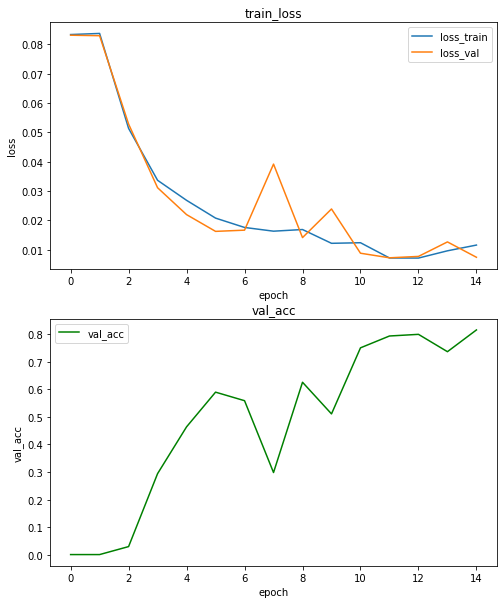

In [20]:
# 62字符 60x160
plot_loss(train_loss,val_loss,val_acc)

In [0]:
# 62字符 60x160
plot_loss(train_loss,val_loss,val_acc)

In [0]:
# 62字符 28x73
plot_loss(train_loss,val_loss,val_acc)

In [0]:
plot_loss(train_loss,val_loss,val_acc)

In [0]:
# 深层的模型
plot_loss(train_loss,val_loss,val_acc)

In [0]:
find_error()

In [0]:
captcha_gen(model_choose='test',num=3000)

In [0]:
test()

In [0]:
torch.cuda.is_available()

In [0]:
!pwd

In [0]:
os.listdir()

In [0]:
!/opt/bin/nvidia-smi